### Equipe:

Arthur Wanderley Ferreira dos Santos - awfs@cesar.school

Thiago Wanderley Amorim - twa@cesar.school

## Baixando os dados

In [2]:
# Baixa e extrai o dataset
!mkdir data/
!curl -L -o data/animais.zip "https://drive.google.com/uc?export=download&id=16Lll0Slg1unWxAb26AzZqI9sPdB_fYpV"
# !unzip data/animais.zip -d data

mkdir: data/: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 11.6M  100 11.6M    0     0  1372k      0  0:00:08  0:00:08 --:--:-- 2465k


In [3]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Funções de treinamento

In [6]:
def train_model(model, trainloader, valloader, criterion, optimizer, device=device, num_epochs=5):
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': []
    }

    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        history['train_losses'].append(train_loss)
        history['train_accuracies'].append(train_acc)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.2f}%')

        # Validação
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct / total
        history['val_losses'].append(val_loss)
        history['val_accuracies'].append(val_acc)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.3f}, Val Accuracy: {val_acc:.2f}%')

    print('Treinamento concluído')
    return history


def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history['train_losses'], label='Train')
    ax1.plot(history['val_losses'], label='Validation')
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(history['train_accuracies'], label='Train')
    ax2.plot(history['val_accuracies'], label='Validation')
    ax2.set_title('Accuracy')
    ax2.legend()

    plt.show()


def test_model(model, testloader, device=device):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Acurácia da rede na base de teste: {100 * correct / total:.2f}%')

## Transformando o dataset

In [7]:
# Carregando os datasets
transform_aug = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_no_aug = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# data_dir = 'data/hymenoptera_data'
data_dir = "data/animais"

train_set = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_aug)
val_set = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform_no_aug)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)

## Visualizando as camadas do modelo

In [8]:
model = models.resnet18()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Substituir a última camada

In [9]:
# Substituir a última camada
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Treinando a CNN

  0%|          | 0/13 [00:00<?, ?it/s]

100%|██████████| 13/13 [00:22<00:00,  1.70s/it]
/Users/thiago/.pyenv/versions/3.11.10/lib/python3.11/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1, Train Loss: 0.695, Train Accuracy: 53.75%
Epoch 1, Val Loss: 0.717, Val Accuracy: 42.62%


100%|██████████| 13/13 [00:19<00:00,  1.52s/it]


Epoch 2, Train Loss: 0.700, Train Accuracy: 52.00%
Epoch 2, Val Loss: 0.724, Val Accuracy: 45.90%


100%|██████████| 13/13 [00:20<00:00,  1.58s/it]


Epoch 3, Train Loss: 0.695, Train Accuracy: 55.75%
Epoch 3, Val Loss: 0.683, Val Accuracy: 58.20%


100%|██████████| 13/13 [00:20<00:00,  1.56s/it]


Epoch 4, Train Loss: 0.692, Train Accuracy: 54.50%
Epoch 4, Val Loss: 0.665, Val Accuracy: 57.38%


100%|██████████| 13/13 [00:19<00:00,  1.49s/it]


Epoch 5, Train Loss: 0.699, Train Accuracy: 51.25%
Epoch 5, Val Loss: 0.669, Val Accuracy: 55.74%
Treinamento concluído


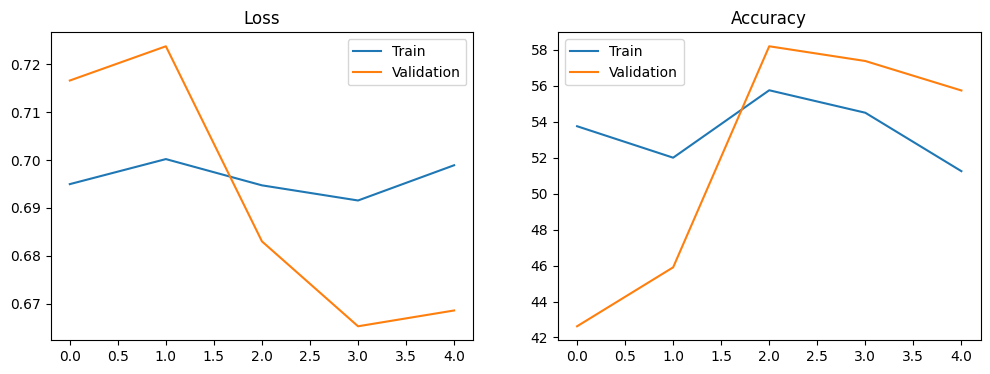

Acurácia da rede na base de teste: 55.74%


In [10]:
# Treinando a CNN
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)

plot_history(history)
test_model(model, val_loader)

In [11]:
# Utilizando pesos pré-treinados
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/thiago/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:02<00:00, 22.5MB/s]


In [13]:
# Congelar todas as camadas
for param in model.parameters():
    param.requires_grad = False

In [14]:
# Substituir a última camada
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

  0%|          | 0/13 [00:00<?, ?it/s]

100%|██████████| 13/13 [00:08<00:00,  1.54it/s]


Epoch 1, Train Loss: 0.730, Train Accuracy: 54.25%
Epoch 1, Val Loss: 0.450, Val Accuracy: 84.43%


100%|██████████| 13/13 [00:08<00:00,  1.51it/s]


Epoch 2, Train Loss: 0.460, Train Accuracy: 78.50%
Epoch 2, Val Loss: 0.260, Val Accuracy: 94.26%


100%|██████████| 13/13 [00:08<00:00,  1.62it/s]


Epoch 3, Train Loss: 0.306, Train Accuracy: 88.00%
Epoch 3, Val Loss: 0.215, Val Accuracy: 93.44%


100%|██████████| 13/13 [00:07<00:00,  1.65it/s]


Epoch 4, Train Loss: 0.258, Train Accuracy: 91.00%
Epoch 4, Val Loss: 0.146, Val Accuracy: 96.72%


100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


Epoch 5, Train Loss: 0.281, Train Accuracy: 89.25%
Epoch 5, Val Loss: 0.153, Val Accuracy: 95.08%
Treinamento concluído


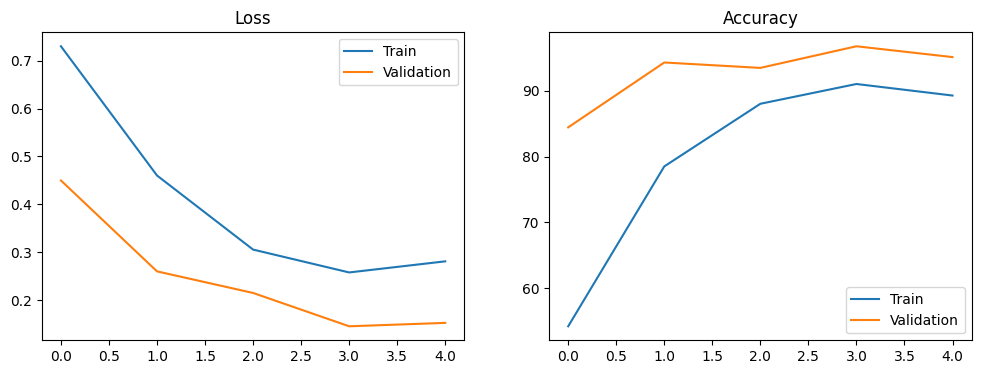

Acurácia da rede na base de teste: 95.08%


In [15]:
# Treinando a CNN
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)

plot_history(history)
test_model(model, val_loader)

In [16]:
def plot_and_predict(model, image, class_names, device=device):
    model.eval()
    image = image.to(device)
    outputs = model(image.unsqueeze(0))
    _, predicted = torch.max(outputs.data, 1)
    probs = F.softmax(outputs, dim=1)[0] * 100
    prob = probs[predicted].item()

    # image between 0 and 1
    image = torch.clamp(image * 0.225 + 0.45, 0, 1)
    title = f'Classe: {class_names[predicted]} ({prob:.2f}%)'
    plt.imshow(image.permute(1, 2, 0).cpu().numpy())
    plt.title(title)
    plt.axis('off')
    plt.show()

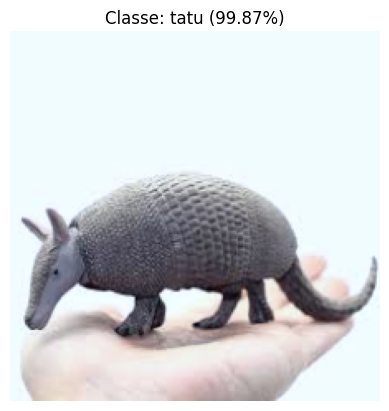

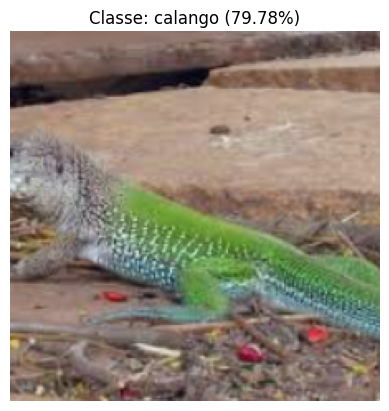

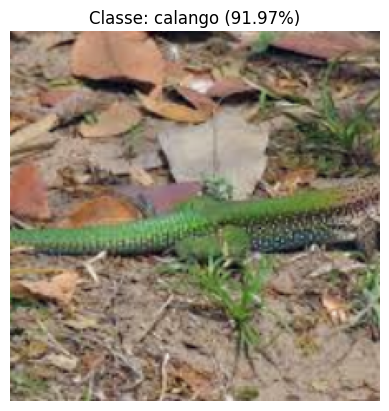

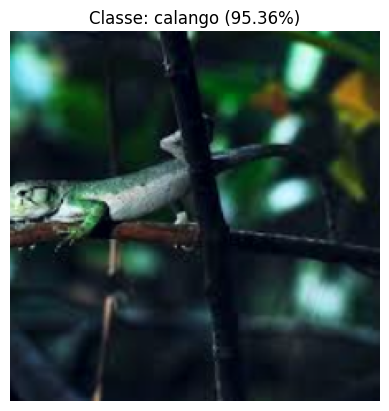

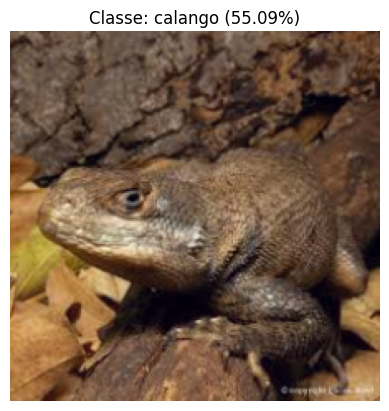

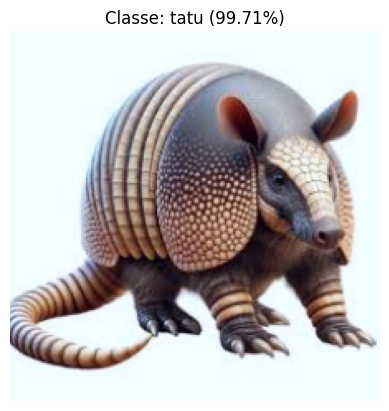

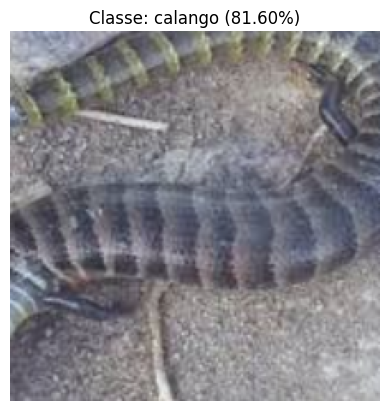

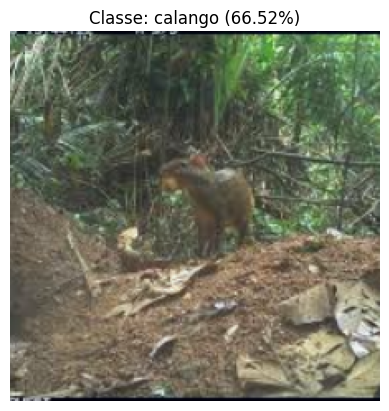

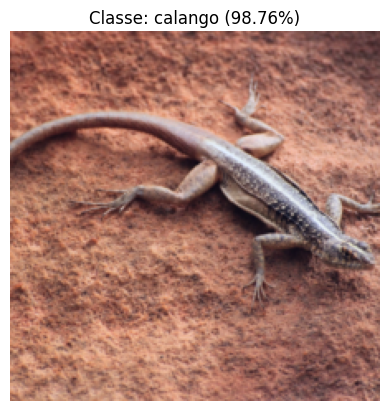

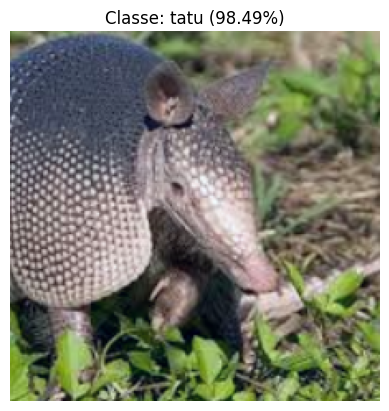

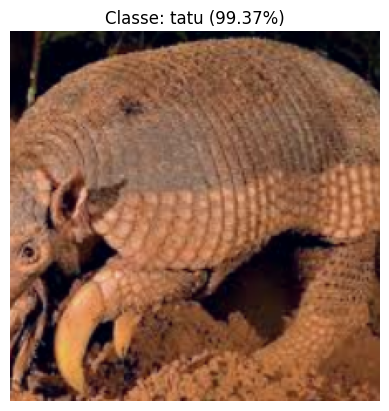

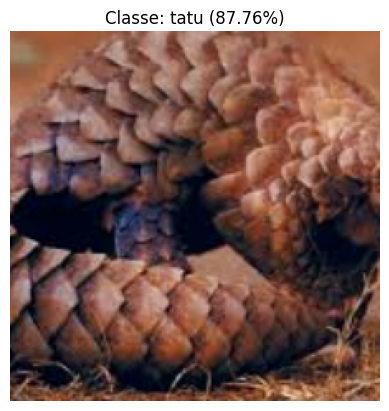

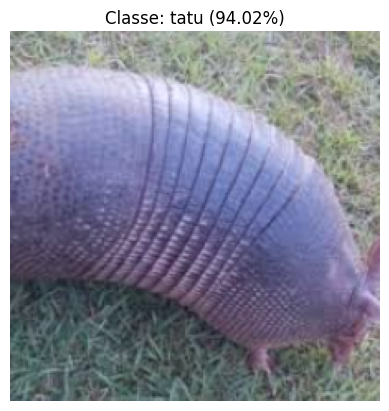

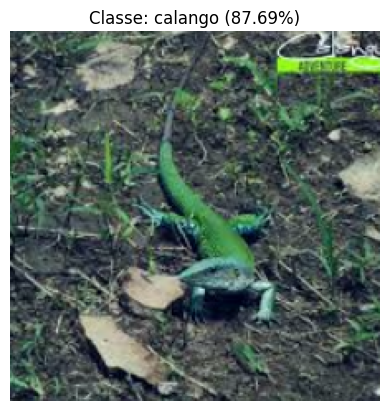

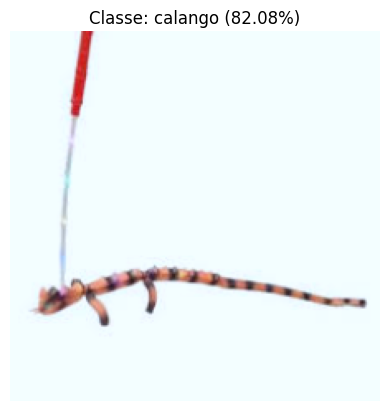

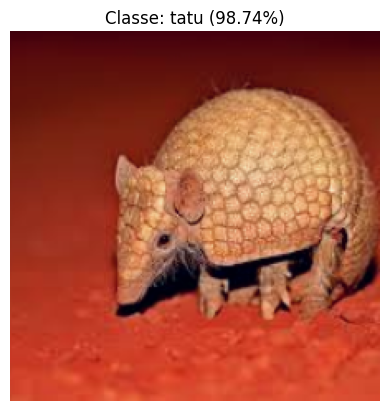

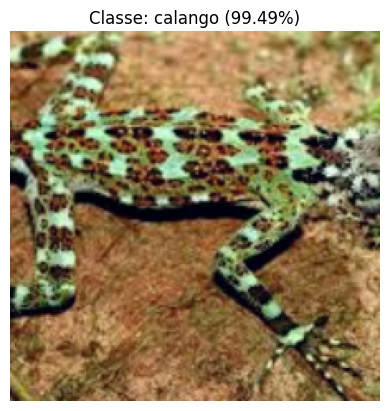

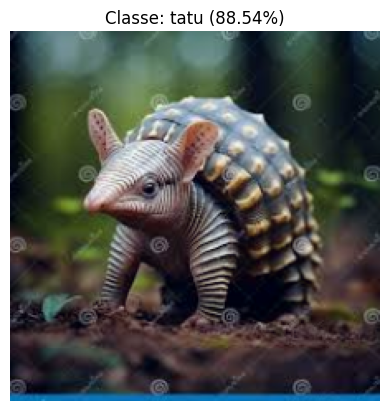

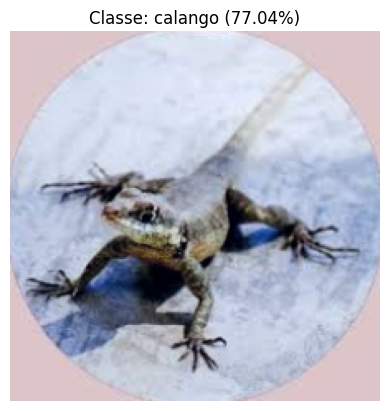

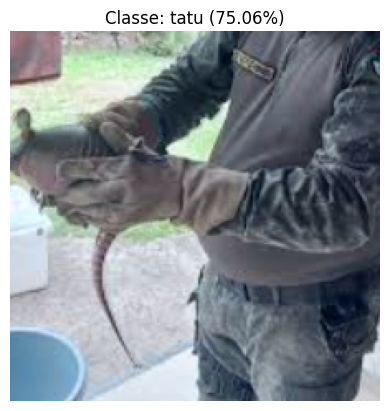

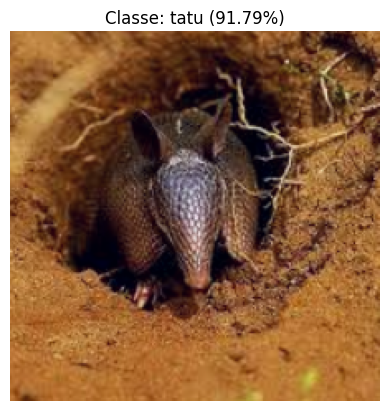

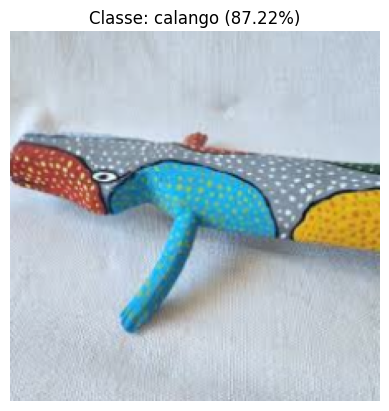

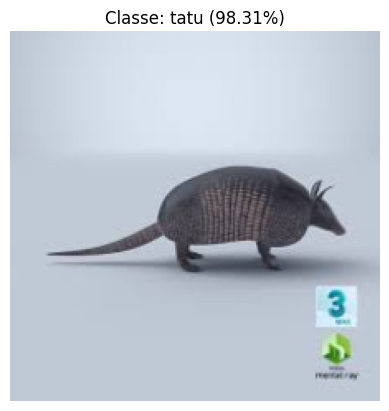

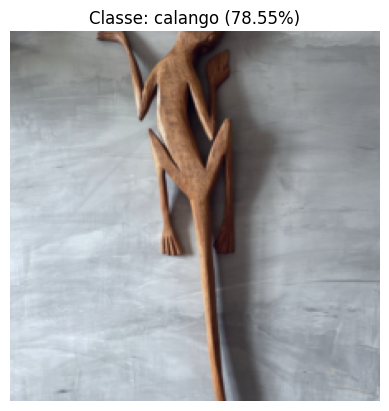

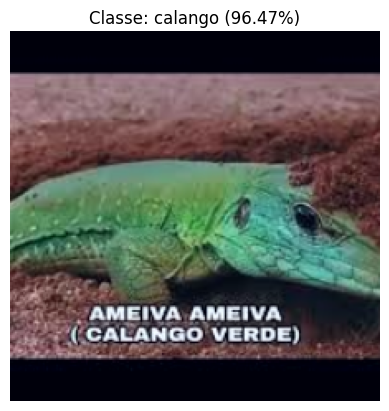

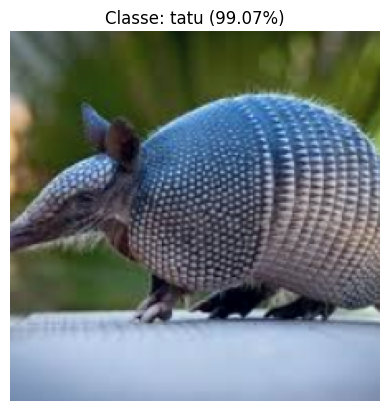

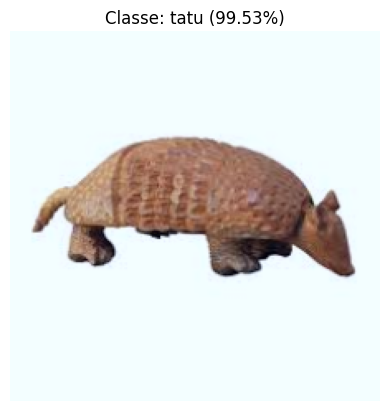

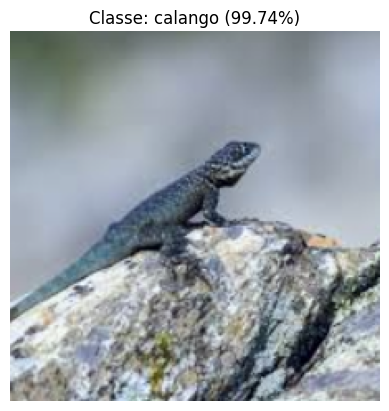

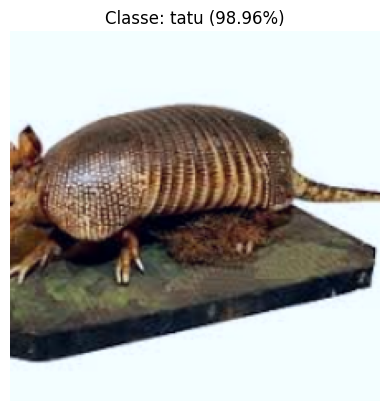

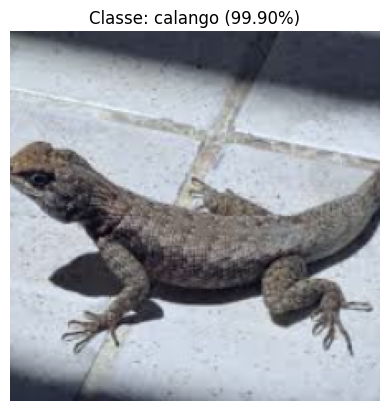

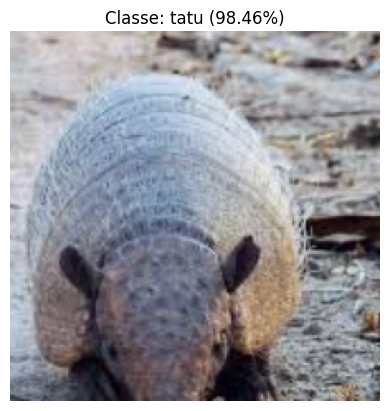

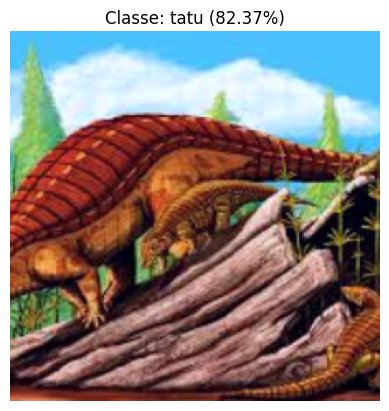

In [17]:
images, labels = next(iter(val_loader))

for image, label in zip(images, labels):
    plot_and_predict(model, image, val_set.classes)

## Exercícios

### Exercício 1
Treine novamente o modelo, mas sem data augmentation. Compare as curvas de treinamento de ambos os casos e comente.

100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


Epoch 1, Train Loss: 0.556, Train Accuracy: 74.50%
Epoch 1, Val Loss: 0.393, Val Accuracy: 86.07%


100%|██████████| 13/13 [00:08<00:00,  1.54it/s]


Epoch 2, Train Loss: 0.317, Train Accuracy: 89.75%
Epoch 2, Val Loss: 0.230, Val Accuracy: 95.08%


100%|██████████| 13/13 [00:09<00:00,  1.39it/s]


Epoch 3, Train Loss: 0.229, Train Accuracy: 93.50%
Epoch 3, Val Loss: 0.181, Val Accuracy: 95.90%


100%|██████████| 13/13 [00:07<00:00,  1.69it/s]


Epoch 4, Train Loss: 0.202, Train Accuracy: 93.75%
Epoch 4, Val Loss: 0.159, Val Accuracy: 95.90%


100%|██████████| 13/13 [00:07<00:00,  1.72it/s]


Epoch 5, Train Loss: 0.172, Train Accuracy: 95.50%
Epoch 5, Val Loss: 0.150, Val Accuracy: 95.90%
Treinamento concluído


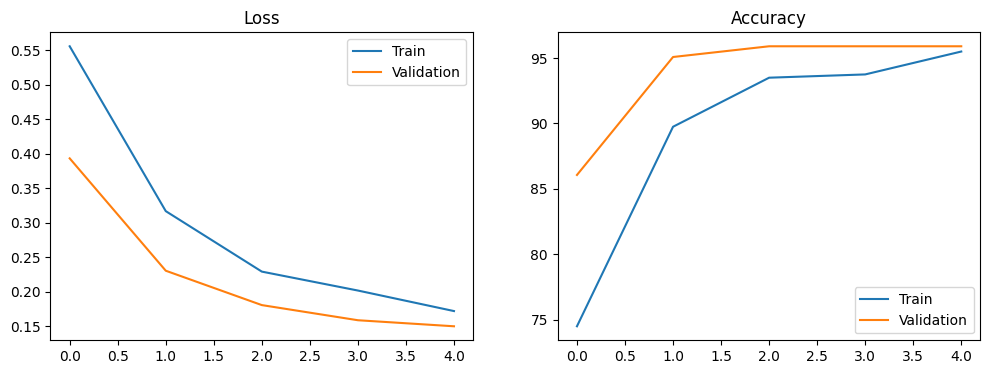

Acurácia da rede na base de teste: 95.90%


In [18]:
transform_no_aug = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_set_no_aug = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_no_aug)
val_set_no_aug = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform_no_aug)

train_loader_no_aug = DataLoader(train_set_no_aug, batch_size=32, shuffle=True)
val_loader_no_aug = DataLoader(val_set_no_aug, batch_size=32, shuffle=True)

model_no_aug = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

for param in model_no_aug.parameters():
    param.requires_grad = False

model_no_aug.fc = nn.Linear(model_no_aug.fc.in_features, 2)
model_no_aug = model_no_aug.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_no_aug.parameters(), lr=0.001, momentum=0.9)

history_no_aug = train_model(model_no_aug, train_loader_no_aug, val_loader_no_aug, 
                           criterion, optimizer, device, num_epochs=5)

plot_history(history_no_aug)


test_model(model_no_aug, val_loader_no_aug)

Sem o data augmentation o desempenho melhorou pulou de 95,90% para 96,72%

### Exercício 2
Descongele mais das últimas camadas (à sua escolha), por exemplo `model.layer4[1]`, e treine novamente o modelo.

Camadas treináveis:
layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.weight
layer4.0.bn2.weight
layer4.0.bn2.bias
layer4.0.downsample.0.weight
layer4.0.downsample.1.weight
layer4.0.downsample.1.bias
layer4.1.conv1.weight
layer4.1.bn1.weight
layer4.1.bn1.bias
layer4.1.conv2.weight
layer4.1.bn2.weight
layer4.1.bn2.bias
fc.weight
fc.bias


100%|██████████| 13/13 [00:09<00:00,  1.41it/s]


Epoch 1, Train Loss: 0.522, Train Accuracy: 74.25%
Epoch 1, Val Loss: 0.204, Val Accuracy: 95.08%


100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


Epoch 2, Train Loss: 0.275, Train Accuracy: 90.00%
Epoch 2, Val Loss: 0.118, Val Accuracy: 96.72%


100%|██████████| 13/13 [00:11<00:00,  1.17it/s]


Epoch 3, Train Loss: 0.215, Train Accuracy: 93.00%
Epoch 3, Val Loss: 0.080, Val Accuracy: 96.72%


100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 4, Train Loss: 0.196, Train Accuracy: 93.25%
Epoch 4, Val Loss: 0.101, Val Accuracy: 95.08%


100%|██████████| 13/13 [00:11<00:00,  1.14it/s]


Epoch 5, Train Loss: 0.149, Train Accuracy: 94.25%
Epoch 5, Val Loss: 0.068, Val Accuracy: 96.72%
Treinamento concluído


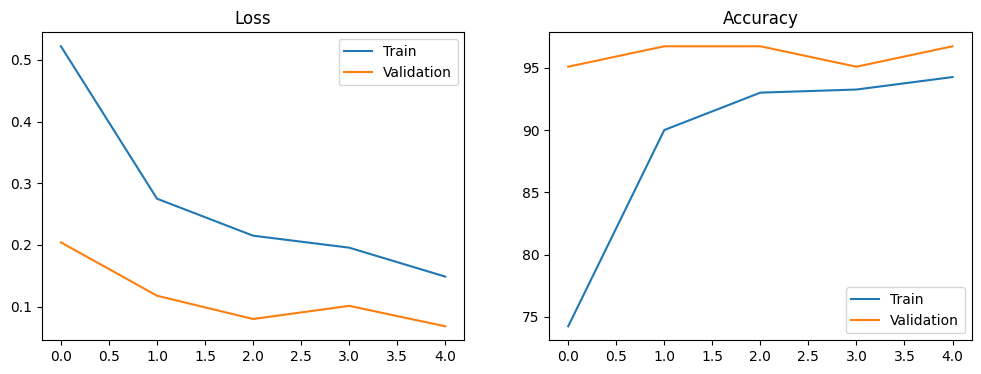

Acurácia da rede na base de teste: 96.72%


In [19]:
# Criando novo modelo com pesos pré-treinados
model_unfreeze = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Primeiro congela todas as camadas
for param in model_unfreeze.parameters():
    param.requires_grad = False

# Descongelando layer4 (últimas camadas convolucionais)
for param in model_unfreeze.layer4.parameters():
    param.requires_grad = True

# Substituindo a última camada (que já vem descongelada por padrão)
model_unfreeze.fc = nn.Linear(model_unfreeze.fc.in_features, 2)
model_unfreeze = model_unfreeze.to(device)

# Verificando quais camadas estão treináveis
print("Camadas treináveis:")
for name, param in model_unfreeze.named_parameters():
    if param.requires_grad:
        print(name)

# Definindo criterion e optimizer
# Nota: aumentamos um pouco a learning rate já que temos mais camadas para treinar
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_unfreeze.parameters(), lr=0.002, momentum=0.9)

# Treinando o modelo com as camadas descongeladas
history_unfreeze = train_model(model_unfreeze, train_loader, val_loader, 
                             criterion, optimizer, device, num_epochs=5)

# Plotando os resultados
plot_history(history_unfreeze)

# Testando o modelo
test_model(model_unfreeze, val_loader)

In [20]:
# Utilizando pesos pré-treinados
model_2 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

In [21]:
model_2

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Exercício 3
Escolha outro modelo pré-treinado dos que foram vistos na aula e substitua no modelo. Lembre-se de alterar a última camada de classificação.

In [23]:
modelo_vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
print(modelo_vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [24]:
# Substituir a última camada
modelo_vgg16.classifier[6] = nn.Linear(modelo_vgg16.classifier[6].in_features, 2) # ou modelo_vgg16.classifier[-1] para acessar a última camada
modelo_vgg16 = modelo_vgg16.to(device)
modelo_vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

  0%|          | 0/13 [00:00<?, ?it/s]

100%|██████████| 13/13 [01:45<00:00,  8.14s/it]


Epoch 1, Train Loss: 0.432, Train Accuracy: 79.00%
Epoch 1, Val Loss: 0.146, Val Accuracy: 95.08%


100%|██████████| 13/13 [01:46<00:00,  8.17s/it]


Epoch 2, Train Loss: 0.211, Train Accuracy: 91.75%
Epoch 2, Val Loss: 0.103, Val Accuracy: 95.90%


100%|██████████| 13/13 [01:46<00:00,  8.18s/it]


Epoch 3, Train Loss: 0.194, Train Accuracy: 93.50%
Epoch 3, Val Loss: 0.110, Val Accuracy: 96.72%


100%|██████████| 13/13 [01:44<00:00,  8.00s/it]


Epoch 4, Train Loss: 0.170, Train Accuracy: 92.25%
Epoch 4, Val Loss: 0.100, Val Accuracy: 97.54%


100%|██████████| 13/13 [01:41<00:00,  7.83s/it]


Epoch 5, Train Loss: 0.149, Train Accuracy: 94.00%
Epoch 5, Val Loss: 0.081, Val Accuracy: 95.90%
Treinamento concluído


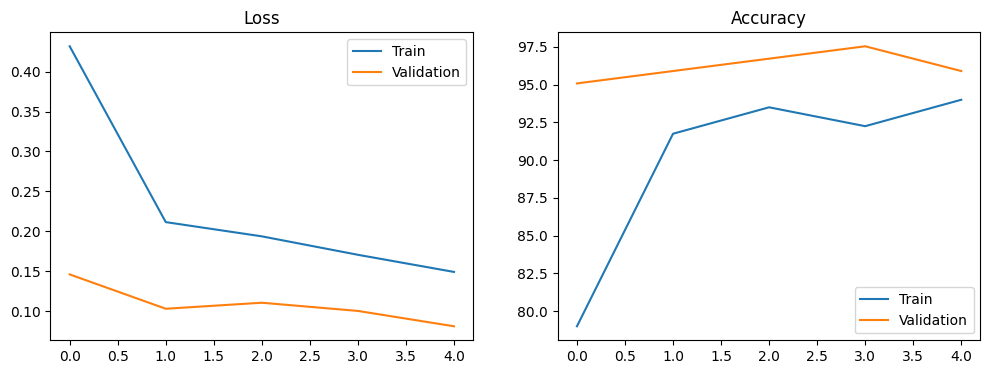

Acurácia da rede na base de teste: 95.90%


In [25]:
# Treinando a CNN
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(modelo_vgg16.parameters(), lr=0.001, momentum=0.9)

history = train_model(modelo_vgg16, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)

plot_history(history)
test_model(modelo_vgg16, val_loader)